https://www.kaggle.com/datasets/manishshah120/facial-expression-recog-image-ver-of-fercdataset

In [134]:
import kagglehub
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation, Conv2D, MaxPooling2D, BatchNormalization, Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from sklearn.metrics import confusion_matrix, classification_report

# 1. Descarga de la base de datos

In [57]:


# Descargar dataset
path = kagglehub.dataset_download("manishshah120/facial-expression-recog-image-ver-of-fercdataset")
print("Path to dataset files:", path)

# Carpeta destino
dest_path = "imagenes"
os.makedirs(dest_path, exist_ok=True)

# Copiar archivos y carpetas
for item in os.listdir(path):
    source = os.path.join(path, item)
    dest = os.path.join(dest_path, item)

    if os.path.isfile(source):
        shutil.copy(source, dest)
    elif os.path.isdir(source):
        shutil.copytree(source, dest, dirs_exist_ok=True)
        print(f"Carpeta copiada: {item}")

print("Archivos y carpetas copiados a:", dest_path)


100%|██████████| 72.0M/72.0M [00:01<00:00, 47.2MB/s]

Extracting files...


Path to dataset files: /Users/jonatanlondonotaborda/.cache/kagglehub/datasets/manishshah120/facial-expression-recog-image-ver-of-fercdataset/versions/1
Carpeta copiada: Dataset
Archivos y carpetas copiados a: imagenes


# 2. Construcción de los arreglos con las imagenes

In [120]:
X=[]
Z=[]

IMG_SIZE=150

BASE_DIR = 'imagenes/Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

EXPRESSIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

In [121]:
def assign_label(img,expression):
    return expression

In [122]:
def make_dataset(expression, training=True):
    if training:
        directory = os.path.join(TRAIN_DIR, expression)
    else:
        directory = os.path.join(TEST_DIR, expression)
    
    for img in tqdm(os.listdir(directory)):
        if not img.lower().endswith(VALID_EXTENSIONS):
            print(f"Archivo no válido: {img}")
            continue
        else:
            label = assign_label(img, expression)
            path = os.path.join(directory, img)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            
            X.append(img)
            Z.append(label)

# 3. Separación de los conjuntos de train y test

In [123]:
for expression in EXPRESSIONS:
    print(f"Procesando expresión: {expression}")
    make_dataset(expression, training=True)
    make_dataset(expression, training=False)

Procesando expresión: anger


100%|██████████| 491/491 [00:00<00:00, 12757.57it/s]


Procesando expresión: disgust


100%|██████████| 493/493 [00:00<00:00, 12160.12it/s]


Archivo no válido: .jovianrc


100%|██████████| 55/55 [00:00<00:00, 12454.74it/s]


Procesando expresión: fear


100%|██████████| 528/528 [00:00<00:00, 13346.55it/s]


Procesando expresión: happiness


100%|██████████| 879/879 [00:00<00:00, 13058.36it/s]


Procesando expresión: neutral


100%|██████████| 626/626 [00:00<00:00, 13495.73it/s]


Procesando expresión: sadness


100%|██████████| 594/594 [00:00<00:00, 13862.61it/s]


Procesando expresión: surprise


100%|██████████| 416/416 [00:00<00:00, 13479.74it/s]


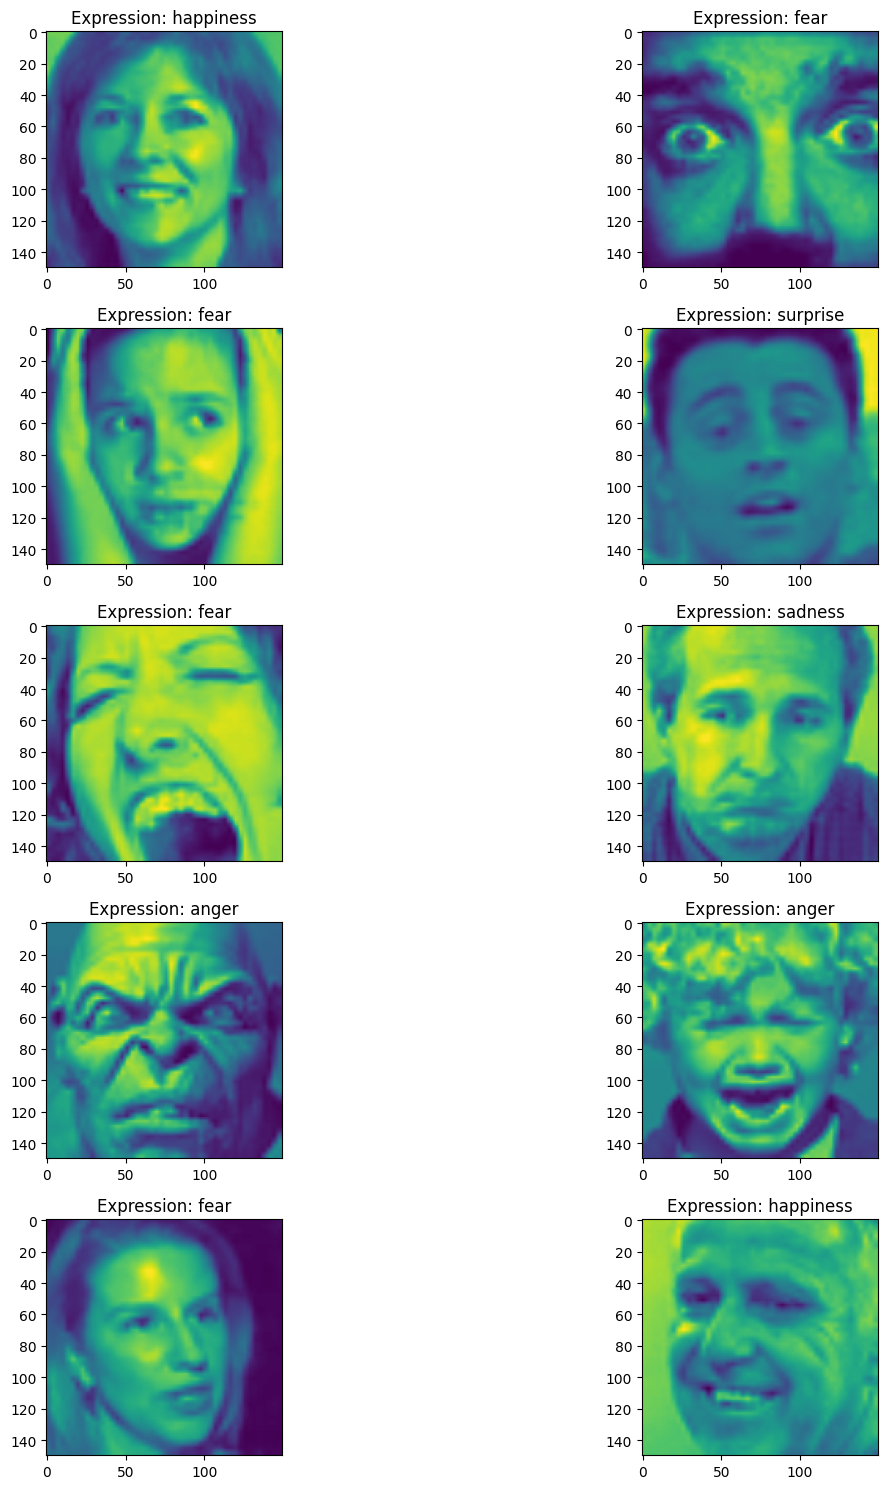

In [124]:
import random as rnd

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rnd.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Expression: '+Z[l])

plt.tight_layout()

## Procesamiento datasets

Se realiza el LabelEncoding, OneHotEncoding y normalización de las imagenes

In [125]:
le=LabelEncoder()
yi=le.fit_transform(Z) #Convierte a labels encoding
Y=to_categorical(yi,7) # convierte a one-hot encoding
X=np.array(X, dtype="float32")
X=X/255 # normaliza las imágenes
X  = np.expand_dims(X, axis=-1)

Se separa el conjunto de datos

In [126]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=yi
)

In [127]:
np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

# 4. Implementación CNN desde cero

In [128]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(7, activation = "softmax"))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 75, 75, 96)     │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 37, 37, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 37, 37, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,599,399 (21.36 MB)

 Trainable params: 5,599,399 (21.36 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
batch_size = 64
epochs = 35

History = model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1)

Epoch 1/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 200s 471ms/step - accuracy: 0.3171 - loss: 1.6951 - val_accuracy: 0.4225 - val_loss: 1.4968
Epoch 2/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 196s 466ms/step - accuracy: 0.4687 - loss: 1.3786 - val_accuracy: 0.5043 - val_loss: 1.2971
Epoch 3/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 200s 474ms/step - accuracy: 0.5516 - loss: 1.1786 - val_accuracy: 0.5335 - val_loss: 1.3024
Epoch 4/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 199s 473ms/step - accuracy: 0.6277 - loss: 1.0019 - val_accuracy: 0.5504 - val_loss: 1.3595
Epoch 5/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 197s 468ms/step - accuracy: 0.7054 - loss: 0.8008 - val_accuracy: 0.5300 - val_loss: 1.6053
Epoch 6/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 199s 473ms/step - accuracy: 0.7793 - loss: 0.6155 - val_accuracy: 0.5191 - val_loss: 1.8002
Epoch 7/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 198s 470ms/step - accuracy: 0.8323 - loss: 0.4611 - val_accuracy: 0.5147 - val_loss: 2.0495
Epoch 8/35
421/421 ━━━━━━━━━━━━━━━━━━━━ 224s 532ms/step - accuracy: 0.8726 -

In [133]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step


In [135]:
confusion_matrix(np.argmax(y_test,axis=1),pred_digits)

array([[ 498,   14,  138,  111,  225,  197,   55],
       [  22,   57,   17,   11,    8,   19,    3],
       [ 151,   14,  441,   96,  209,  229,  140],
       [ 109,   12,   69, 1659,  210,  125,   63],
       [ 155,   10,   89,  146,  884,  228,   38],
       [ 168,   17,  185,  144,  376,  591,   38],
       [  38,    3,  107,   73,   60,   50,  670]])

In [136]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test,axis=1),pred_digits))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42      1238
           1       0.45      0.42      0.43       137
           2       0.42      0.34      0.38      1280
           3       0.74      0.74      0.74      2247
           4       0.45      0.57      0.50      1550
           5       0.41      0.39      0.40      1519
           6       0.67      0.67      0.67      1001

    accuracy                           0.53      8972
   macro avg       0.51      0.50      0.51      8972
weighted avg       0.53      0.53      0.53      8972



In [ ]:
# ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

In [137]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [138]:
import warnings

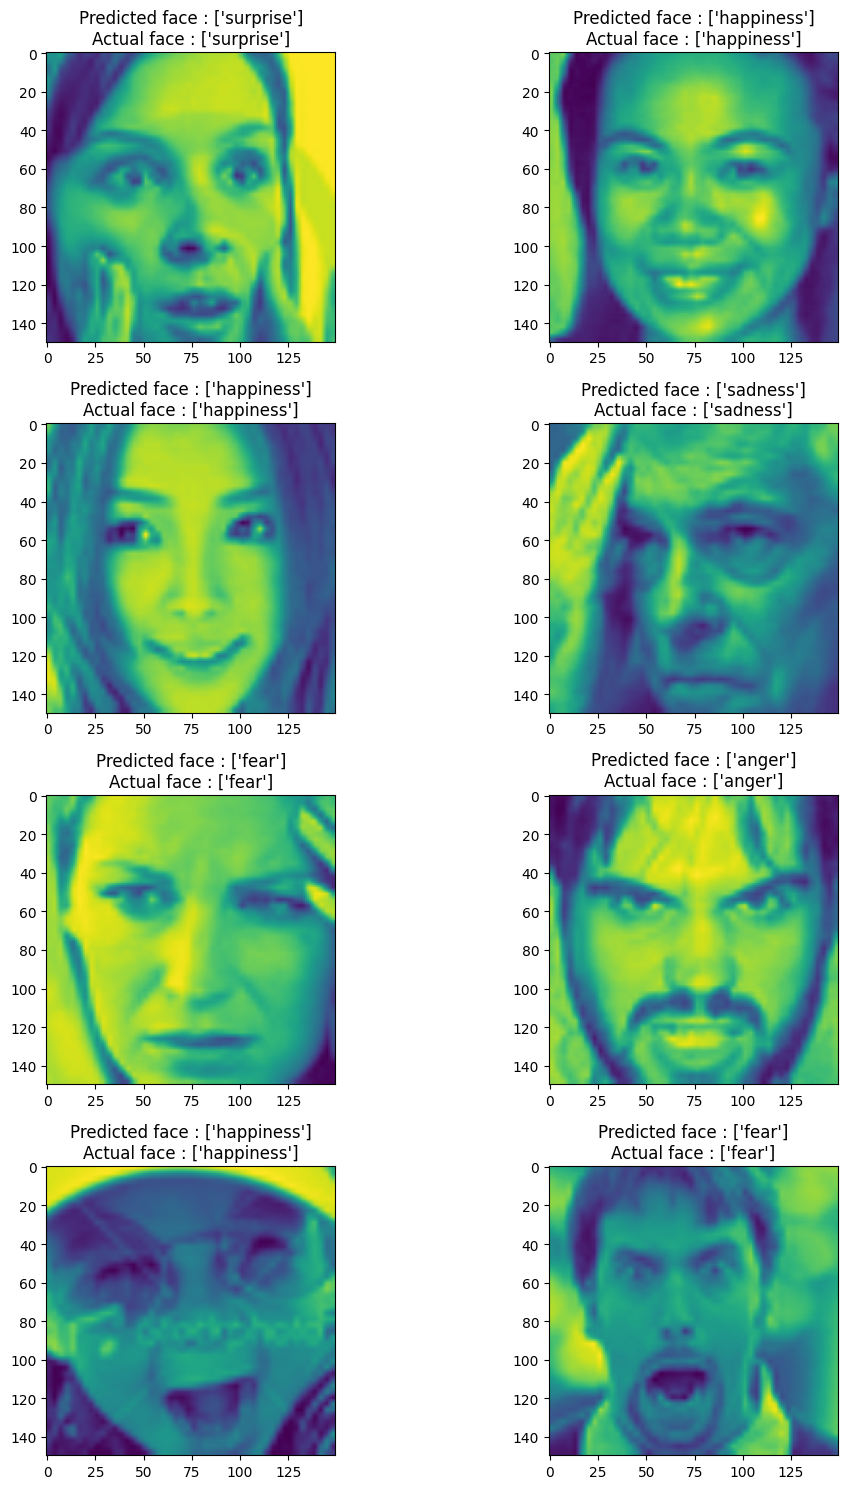

In [140]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[prop_class[count]]])))
        plt.tight_layout()
        count+=1

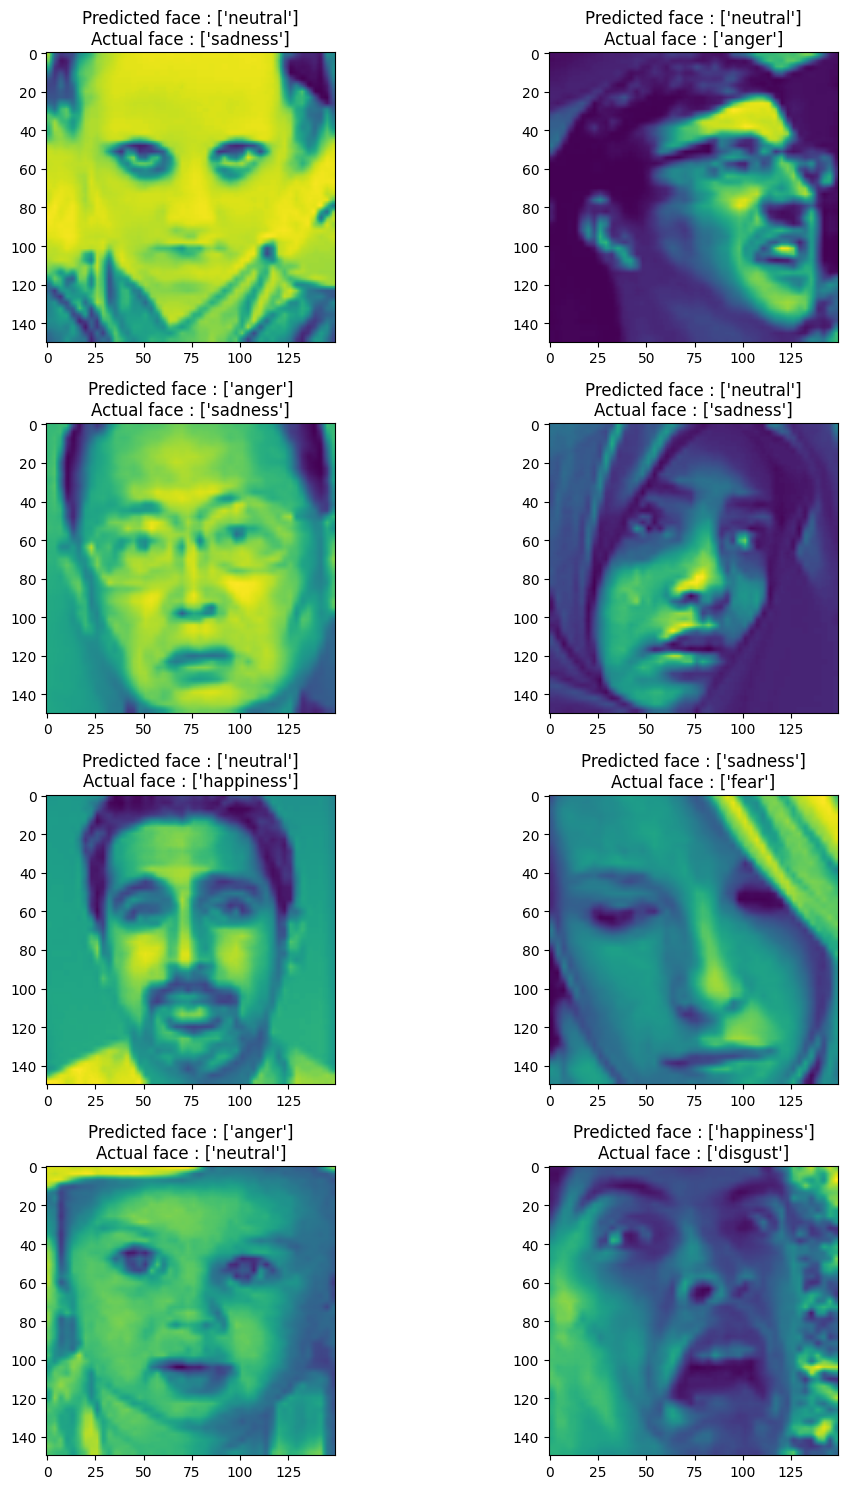

In [142]:
#warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        predict_max=np.argmax(y_test,axis=1)
        ax[i,j].set_title("Predicted face : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual face : "+str(le.inverse_transform([predict_max[mis_class[count]]])))
        plt.tight_layout()
        count+=1

# Transfer Learning y Fine Tunning